In [ ]:
import pandas as pd
import numpy as np
import re

import xgboost as xgb
from sklearn.model_selection import TimeSeriesSplit, GridSearchCV
from sklearn.metrics import mean_squared_error, r2_score
import matplotlib.pyplot as plt
import seaborn as sns

In [ ]:
df = pd.read_csv("furman_monthly.csv", parse_dates=["month"])

#Columns we do NOT want as features
exclude = [
    "community_district","name","month",
    "quality_score","quality_percentile_month",
    "quality_index_0_100","quality_grade","top3_drivers",
    "quality_score_t_plus_6m"
]
feature_cols = [c for c in df.columns if c not in exclude]

#Sanitize column names (XGBoost hates special chars)
def sanitize(name: str) -> str:
    s = str(name)
    s = s.replace("%","pct").replace("$","usd")
    s = re.sub(r"[^\w]+", "_", s)       # non-word chars -> "_"
    s = re.sub(r"_+", "_", s).strip("_")
    s = s.lower()
    return s[:120]

san_map = {}
used = set()
for c in feature_cols:
    base = sanitize(c)
    new = base
    i = 1
    while new in used:      # ensure uniqueness
        i += 1
        new = f"{base}_{i}"
    san_map[c] = new
    used.add(new)

df_san = df.copy()
df_san.rename(columns=san_map, inplace=True)

san_feature_cols = [san_map[c] for c in feature_cols]
label_col = "quality_score_t_plus_6m"

# Build X & y
y = df_san[label_col]
mask = y.notna()
X = df_san.loc[mask, san_feature_cols].apply(pd.to_numeric, errors="coerce")
y = y.loc[mask]
dates = df_san.loc[mask, "month"]

# Time split: train = before 2020, test = 2020+
train_mask = dates < pd.Timestamp("2020-01-01")
X_train, X_test = X[train_mask], X[~train_mask]
y_train, y_test = y[train_mask], y[~train_mask]

print(f"Train: {X_train.shape}, Test: {X_test.shape}")


Train: (7080, 84), Test: (1121, 84)


In [4]:
baseline_model = xgb.XGBRegressor(
    n_estimators=500,
    learning_rate=0.05,
    max_depth=6,
    subsample=0.8,
    colsample_bytree=0.8,
    objective="reg:squarederror",
    random_state=42
)
baseline_model.fit(X_train, y_train)

y_pred = baseline_model.predict(X_test)

mse  = mean_squared_error(y_test, y_pred)   # MSE
rmse = np.sqrt(mse)                         # RMSE
r2   = r2_score(y_test, y_pred)

print(f"Baseline RMSE: {rmse:.3f}")
print(f"Baseline R²:  {r2:.3f}")


Baseline RMSE: 0.059
Baseline R²:  0.916


In [ ]:
from sklearn.model_selection import TimeSeriesSplit, GridSearchCV

tscv = TimeSeriesSplit(n_splits=5)

grid = GridSearchCV(
    estimator=xgb.XGBRegressor(objective="reg:squarederror", random_state=42),
    param_grid={
        "n_estimators": [300, 500, 800],
        "max_depth": [4, 6, 8],
        "learning_rate": [0.01, 0.05, 0.1],
        "subsample": [0.8, 1.0],
        "colsample_bytree": [0.8, 1.0],
    },
    cv=tscv,
    scoring="neg_mean_squared_error",
    verbose=2,
    n_jobs=-1,
)

grid.fit(X_train, y_train)
best_model = grid.best_estimator_

best_cv_rmse = (-grid.best_score_)**0.5
print("Best params:", grid.best_params_)
print(f"Best CV RMSE: {best_cv_rmse:.3f}")

y_pred_best = best_model.predict(X_test)
rmse_best = np.sqrt(mean_squared_error(y_test, y_pred_best))
r2_best   = r2_score(y_test, y_pred_best)
print(f"Test RMSE (best): {rmse_best:.3f}")
print(f"Test R² (best):  {r2_best:.3f}")


Fitting 5 folds for each of 108 candidates, totalling 540 fits
[CV] END colsample_bytree=0.8, learning_rate=0.01, max_depth=4, n_estimators=300, subsample=1.0; total time=   2.8s
[CV] END colsample_bytree=0.8, learning_rate=0.01, max_depth=4, n_estimators=300, subsample=0.8; total time=   3.0s
[CV] END colsample_bytree=0.8, learning_rate=0.01, max_depth=4, n_estimators=300, subsample=0.8; total time=   3.5s
[CV] END colsample_bytree=0.8, learning_rate=0.01, max_depth=4, n_estimators=300, subsample=1.0; total time=   3.5s
[CV] END colsample_bytree=0.8, learning_rate=0.01, max_depth=4, n_estimators=300, subsample=0.8; total time=   3.8s
[CV] END colsample_bytree=0.8, learning_rate=0.01, max_depth=4, n_estimators=300, subsample=1.0; total time=   3.8s
[CV] END colsample_bytree=0.8, learning_rate=0.01, max_depth=4, n_estimators=300, subsample=0.8; total time=   4.0s
[CV] END colsample_bytree=0.8, learning_rate=0.01, max_depth=4, n_estimators=300, subsample=0.8; total time=   4.4s
[CV] END 

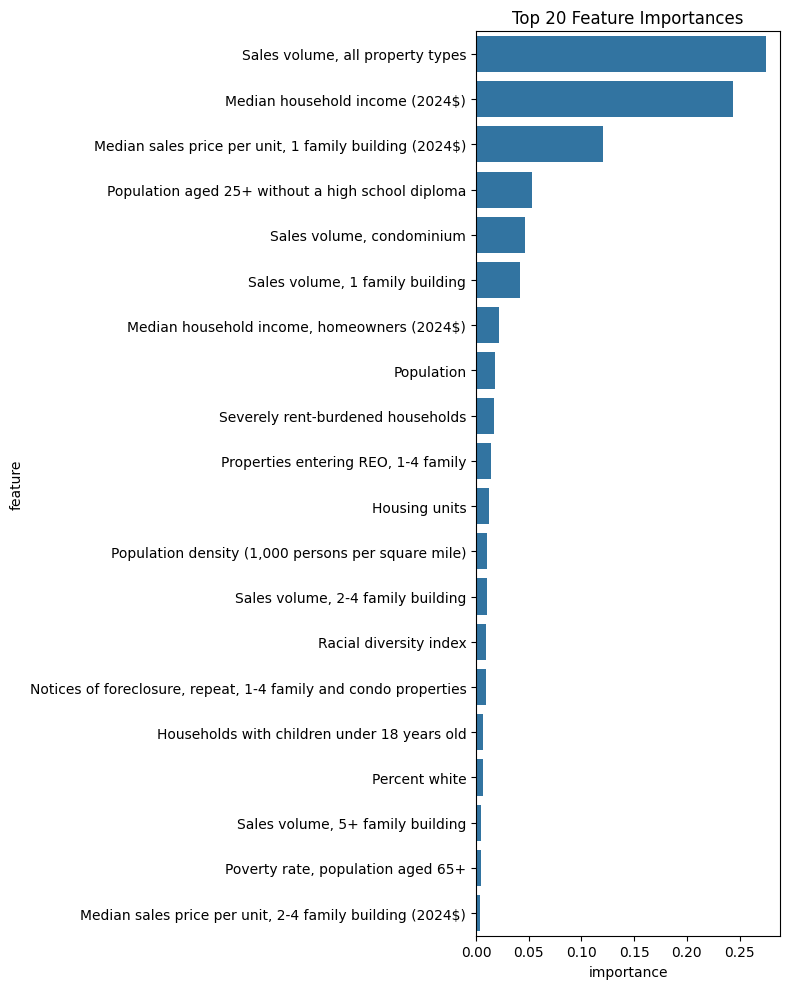

,feature_sanitized,importance,feature
67,sales_volume_all_property_types,0.274624,"Sales volume, all property types"
26,median_household_income_2024usd,0.243692,Median household income (2024$)
33,median_sales_price_per_unit_1_family_building_...,0.120373,"Median sales price per unit, 1 family building..."
49,population_aged_25_without_a_high_school_diploma,0.053535,Population aged 25+ without a high school diploma
68,sales_volume_condominium,0.046544,"Sales volume, condominium"
64,sales_volume_1_family_building,0.041252,"Sales volume, 1 family building"
27,median_household_income_homeowners_2024usd,0.021354,"Median household income, homeowners (2024$)"
48,population,0.018374,Population
74,severely_rent_burdened_households,0.017448,Severely rent-burdened households
57,properties_entering_reo_1_4_family,0.014073,"Properties entering REO, 1-4 family"


In [ ]:
importances = best_model.feature_importances_
imp = pd.DataFrame({"feature_sanitized": san_feature_cols, "importance": importances})
imp = imp.sort_values("importance", ascending=False)

#Map back to original column names
rev_map = {v: k for k, v in san_map.items()}
imp["feature"] = imp["feature_sanitized"].map(rev_map)

plt.figure(figsize=(8, 10))
sns.barplot(x="importance", y="feature", data=imp.head(20))
plt.title("Top 20 Feature Importances")
plt.tight_layout()
plt.show()

imp.head(20)
